# 0.05838-model w/ VAR

In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [34]:
# ----- Загрузка и подготовка данных -----
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
full_data = pd.concat([train, test], ignore_index=True)
full_data['dt'] = pd.to_datetime(full_data['dt'])
full_data = full_data.sort_values('dt').reset_index(drop=True)

train_data = full_data.iloc[:-13]
valid_data = full_data.iloc[-13:].reset_index(drop=True)

train_multi = train_data.set_index('dt')[['high', 'low', 'close']]
valid_multi = valid_data.set_index('dt')[['high', 'low', 'close']]

# Дифференцирование для стационарности
train_diff = train_multi.diff().dropna()

In [35]:
# ----- VAR model -----
var_model = VAR(train_diff)
var_fit = var_model.fit(maxlags=3, ic='aic')
lag_order = var_fit.k_ar

In [37]:
# ----- Valid -----
forecast_diff = var_fit.forecast(train_diff.values[-lag_order:], steps=13)

last_values = train_multi.iloc[-1].values
var_forecast = pd.DataFrame(forecast_diff, columns=train_multi.columns)
var_forecast = var_forecast.cumsum() + last_values

y_true = valid_multi['close'].values
y_pred = var_forecast['close'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8)) * 100)  # Защита от деления на 0

print("\nValidation Metrics:")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"MAPE: {mape:.2f}%")


Validation Metrics:
RMSE: 0.23264
MAE: 0.20540
MAPE: 5.38%


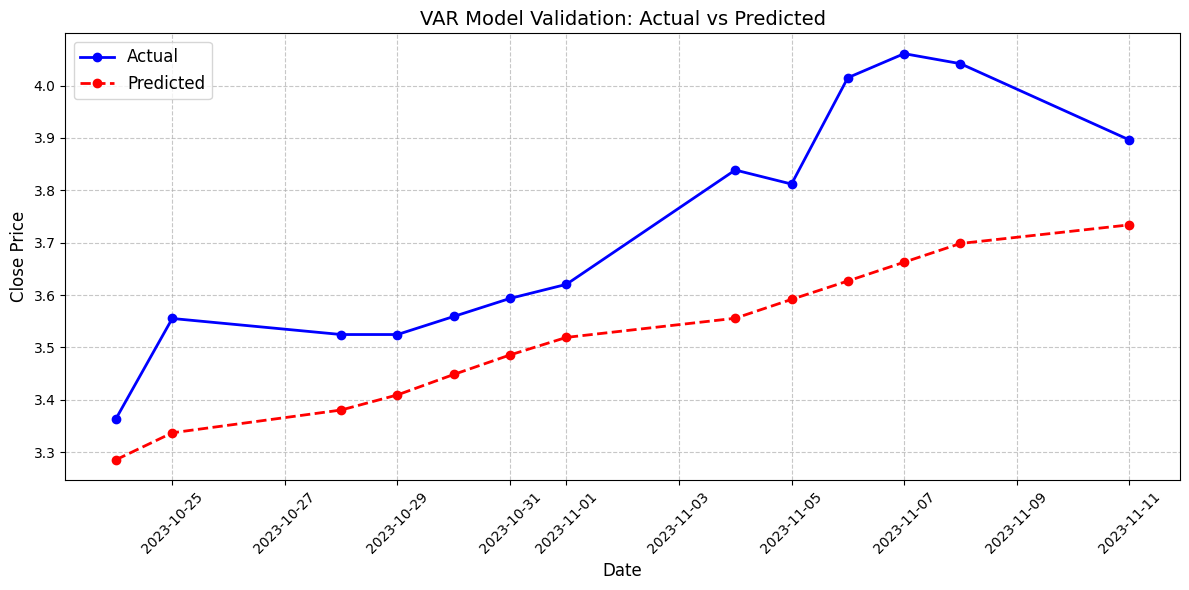

In [38]:
# ----- Valid Visualize -----
plt.figure(figsize=(12, 6))
plt.plot(valid_data['dt'], y_true, 'bo-', label='Actual', linewidth=2, markersize=6)
plt.plot(valid_data['dt'], y_pred, 'ro--', label='Predicted', linewidth=2, markersize=6)
plt.title('VAR Model Validation: Actual vs Predicted', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('validation_metrics.png', dpi=300)
plt.show()

In [39]:
# ----- Final training -----
full_multi = full_data.set_index('dt')[['high', 'low', 'close']]
full_diff = full_multi.diff().dropna()

var_model_final = VAR(full_diff)
var_fit_final = var_model_final.fit(maxlags=3, ic='aic')
lag_order_final = var_fit_final.k_ar


In [40]:
# ----- Forecasting ans -----
forecast_diff_final = var_fit_final.forecast(
    full_diff.values[-lag_order_final:],
    steps=13
)

last_values_final = full_multi.iloc[-1].values
var_forecast_final = pd.DataFrame(forecast_diff_final, columns=full_multi.columns)
var_forecast_final = var_forecast_final.cumsum() + last_values_final

result = pd.DataFrame({
    'ID': range(1, 14),
    'close': var_forecast_final['close'].values
})

result.to_csv('submission.csv', index=False)
print("\nFinal predictions saved to 'submission.csv'")


Final predictions saved to 'submission.csv'


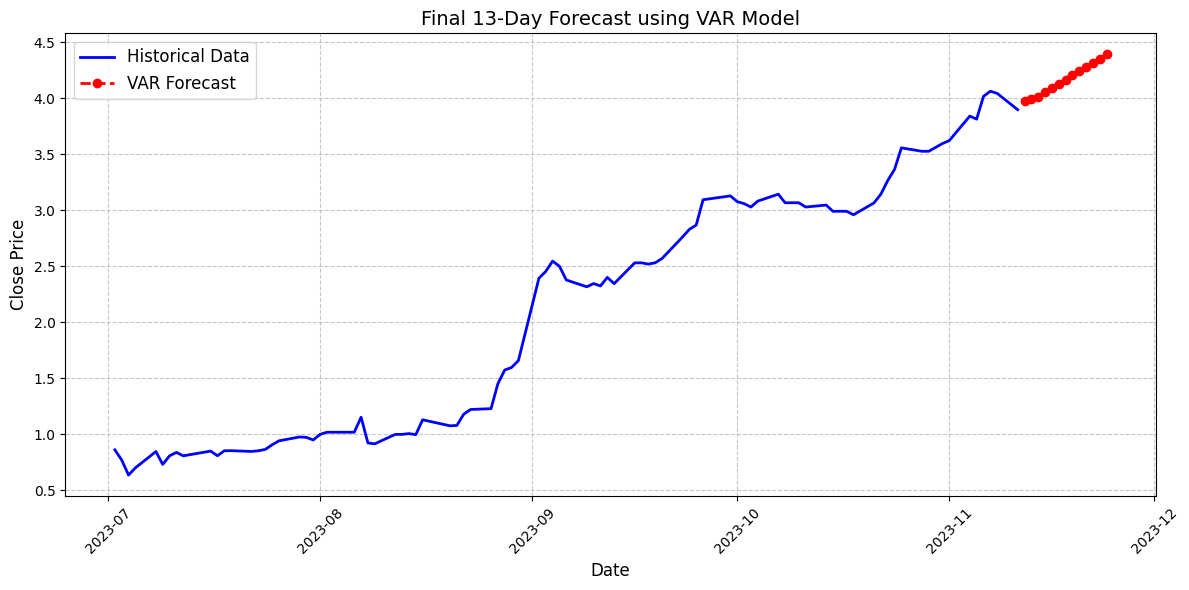


First 5 predictions:
   ID     close
0   1  3.977393
1   2  3.992902
2   3  4.007069
3   4  4.053793
4   5  4.092733


In [41]:
# ----- Final forecast Vusialize -----
plt.figure(figsize=(12, 6))
plt.plot(full_data['dt'], full_data['close'], 'b-', label='Historical Data', linewidth=2)
future_dates = pd.date_range(
    start=full_data['dt'].max() + pd.Timedelta(days=1),
    periods=13,
    freq='D'
)
plt.plot(future_dates, result['close'], 'ro--', label='VAR Forecast', linewidth=2, markersize=6)
plt.title('Final 13-Day Forecast using VAR Model', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('final_forecast.png', dpi=300)
plt.show()

print("\nFirst 5 predictions:")
print(result.head())